### Engineers' Salary Prediction Challenge

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer

#### Wczytanie danych

In [2]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))

train.head()

,obs,job_title,job_posted_date,salary_category,job_state,feature_1,feature_2,feature_3,feature_4,feature_5,...,job_desc_291,job_desc_292,job_desc_293,job_desc_294,job_desc_295,job_desc_296,job_desc_297,job_desc_298,job_desc_299,job_desc_300
0,1,Others,2024/07,High,NY,A,0.6429,False,False,True,...,-0.362079,-0.499308,-0.367894,-0.214881,0.014870,-0.271177,-0.113347,-0.587955,-0.919095,-0.207340
1,2,Job_Title_1,2024/07,Low,CA,A,0.4678,False,False,False,...,-0.300989,-0.415411,-0.341824,-0.319064,0.042322,-0.124755,0.023489,-0.893224,-0.823024,0.112364
2,3,Others,2024/07,Low,CA,A,0.4610,False,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,Others,2024/07,Low,CA,A,0.5064,False,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,Others,2024/07,Low,CA,A,0.4640,False,False,False,...,-0.406159,-0.654657,-0.074398,-0.464479,0.081037,-0.136992,-0.276270,-0.696853,-0.601466,0.089939


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Columns: 317 entries, obs to job_desc_300
dtypes: bool(9), float64(302), int64(1), object(5)
memory usage: 3.0+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 854 entries, 0 to 853
Columns: 316 entries, obs to job_desc_300
dtypes: bool(9), float64(302), int64(1), object(4)
memory usage: 2.0+ MB


In [5]:
def compare_train_test(column):
    train_values = train[column].value_counts().reset_index(name='train_count')
    test_values = test[column].value_counts().reset_index(name='test_count')
    return pd.merge(test_values, train_values, how='outer', on=column)

c_job_title = compare_train_test('job_title')
c_job_state = compare_train_test('job_state')

### <center>Braki w kolumnach</center>

In [6]:
train.isnull().sum().sort_values(ascending=False)

feature_10         446
job_state           27
job_posted_date      1
obs                  0
job_desc_193         0
                  ... 
job_desc_091         0
job_desc_090         0
job_desc_089         0
job_desc_088         0
job_desc_300         0
Length: 317, dtype: int64

In [7]:
test.isnull().sum().sort_values(ascending=False)

feature_10      314
job_state        13
obs               0
job_desc_193      0
job_desc_200      0
               ... 
job_desc_091      0
job_desc_090      0
job_desc_089      0
job_desc_088      0
job_desc_300      0
Length: 316, dtype: int64

### <center>Analiza kolumn job_desc</center>

In [8]:
job_desc_columns = [col for col in train.columns if col.startswith('job_desc_')]

train['has_description'] = (train[job_desc_columns].sum(axis=1) != 0).astype(int)
test['has_description'] = (test[job_desc_columns].sum(axis=1) != 0).astype(int)

#### PCA dla kolumn job_desc

In [9]:
# job_desc_pca = PCA(n_components=2, random_state=42).fit(train[job_desc_columns])
#
# train_decomposed = job_desc_pca.transform(train[job_desc_columns])
# test_decomposed = job_desc_pca.transform(test[job_desc_columns])
#
# train.drop(columns=job_desc_columns, inplace=True)
# test.drop(columns=job_desc_columns, inplace=True)
#
# train = pd.concat([train, pd.DataFrame(data=train_decomposed, columns=['pca_job_desc_0', 'pca_job_desc_1'])], axis=1)
# test = pd.concat([test, pd.DataFrame(data=test_decomposed, columns=['pca_job_desc_0', 'pca_job_desc_1'])], axis=1)

### <center>Miesiąc i rok</center>

In [10]:
train['job_posted_date'] = pd.to_datetime(train['job_posted_date'], format='%Y/%m')
train['month'] = train['job_posted_date'].dt.month
train['year'] = train['job_posted_date'].dt.year
train.drop(columns=['job_posted_date'], inplace=True)

test['job_posted_date'] = pd.to_datetime(test['job_posted_date'], format='%Y/%m')
test['month'] = test['job_posted_date'].dt.month
test['year'] = test['job_posted_date'].dt.year
test.drop(columns=['job_posted_date'], inplace=True)

### <center>Porównanie wybranych kolumn kategorycznych w train/test</center>

#### <center>Stan w którym jest oferta pracy "job_state"</center>

In [11]:
c_job_state

,job_state,test_count,train_count
0,AK,NaN,1.0
1,AL,1.0,1.0
2,AR,1.0,1.0
3,AZ,2.0,2.0
4,CA,391.0,559.0
5,CO,4.0,8.0
6,CT,8.0,2.0
7,DC,4.0,8.0
8,FL,1.0,6.0
9,GA,4.0,10.0


#### Zmiana stanów na regiony USA

In [12]:
west_states = [
    'AK', 'AZ', 'CA', 'CO', 'HI', 'ID',
    'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY'
]

central_states = [
    'AR', 'IA', 'IL', 'IN', 'KS', 'KY', 'LA',
    'MI', 'MN', 'MO', 'ND', 'NE', 'OH',
    'OK', 'SD', 'TX', 'WI'
]

east_states = [
    'AL', 'CT', 'DE', 'FL', 'GA', 'MA', 'MD',
    'ME', 'MS', 'NC', 'NH', 'NJ', 'NY', 'PA',
    'RI', 'SC', 'TN', 'VA', 'VT', 'WV', 'DC'
]

def map_state_to_region(state):
    if state in west_states:
        return 'West'
    elif state in central_states:
        return 'Central'
    elif state in east_states:
        return 'East'
    else:
        return 'None'

train['job_region'] = train['job_state'].apply(map_state_to_region)
test['job_region'] = test['job_state'].apply(map_state_to_region)

#### <center>WYKRES: Stan USA, a wysokość pensji</center>

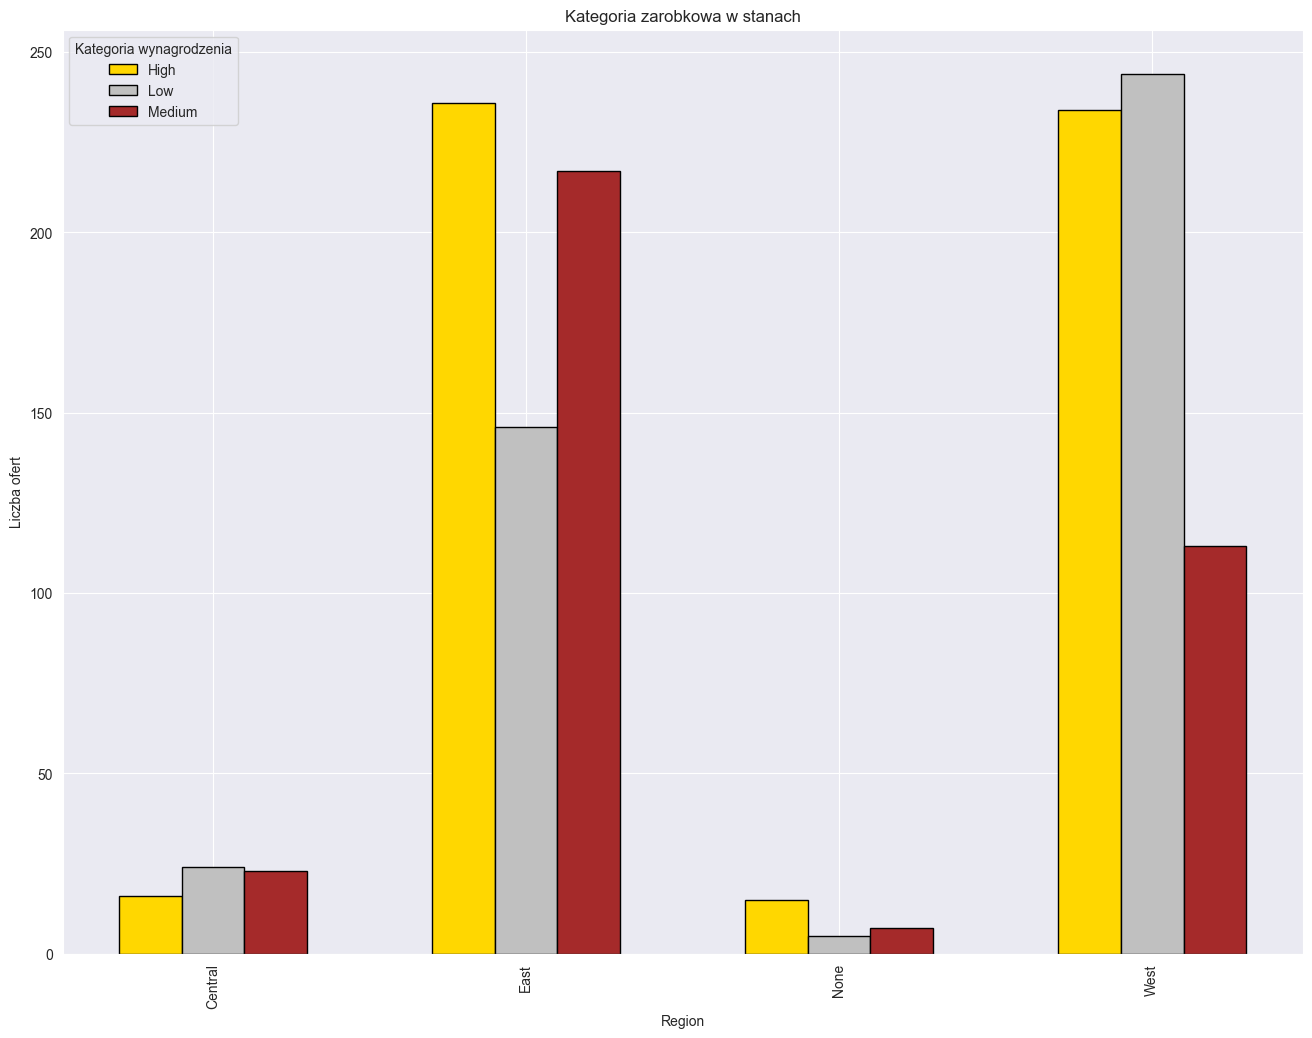

In [13]:
salary_types = train['salary_category'].unique()

show_every_region = train.groupby(['job_region', 'salary_category']).size().unstack(fill_value=0).reindex(columns=salary_types, fill_value=0).stack().reset_index(name='Count')

width = 0.2
x = np.arange(len(show_every_region['job_region'].unique()))
my_xticks = [x - width, x, x + width]
colors = ['gold', 'silver', 'brown']

fig, ax = plt.subplots(figsize=(16, 12))

for i, salary in enumerate(salary_types):
    ax.bar(
        x=my_xticks[i],
        height=show_every_region.loc[(show_every_region['salary_category'] == salary), 'Count'],
        width=width,
        label=salary,
        color=colors[i],
        edgecolor='black',
        alpha=1,
    )

ax.grid(True)
ax.set_xticks(x)
ax.set_xticklabels(show_every_region['job_region'].unique(), rotation=90)
ax.set_xlabel('Region')
ax.set_ylabel('Liczba ofert')
ax.set_title('Kategoria zarobkowa w stanach')
ax.legend(title='Kategoria wynagrodzenia')

#### Co zrobić z job_state?

Testowano:
- usunięcie -> tak sobie
- zmiana na "job_region" i kodowanie one-hot -> narazie najlepiej

In [14]:
job_region_one_hot = OneHotEncoder(sparse_output=False)
job_region_one_hot.fit(train[['job_region']])

train = pd.concat([train, pd.DataFrame(job_region_one_hot.transform(train[['job_region']]), columns=job_region_one_hot.categories_[0])], axis=1)
test = pd.concat([test, pd.DataFrame(job_region_one_hot.transform(test[['job_region']]), columns=job_region_one_hot.categories_[0])], axis=1)

train.drop(columns=['job_state', 'job_region'], inplace=True)
test.drop(columns=['job_state', 'job_region'], inplace=True)

#### <center>Stanowisko pracy "job_title"</center>

In [15]:
c_job_title

,job_title,test_count,train_count
0,Job_Title_1,13,27
1,Job_Title_10,46,53
2,Job_Title_11,1,9
3,Job_Title_12,7,7
4,Job_Title_13,13,11
5,Job_Title_14,2,3
6,Job_Title_15,2,4
7,Job_Title_16,3,6
8,Job_Title_17,3,4
9,Job_Title_18,1,4


In [16]:
(train['job_title'].isna().sum(), test['job_title'].isna().sum())

(0, 0)

#### <center>WYKRES: Stanowisko pracy a wysokość pensji</center>

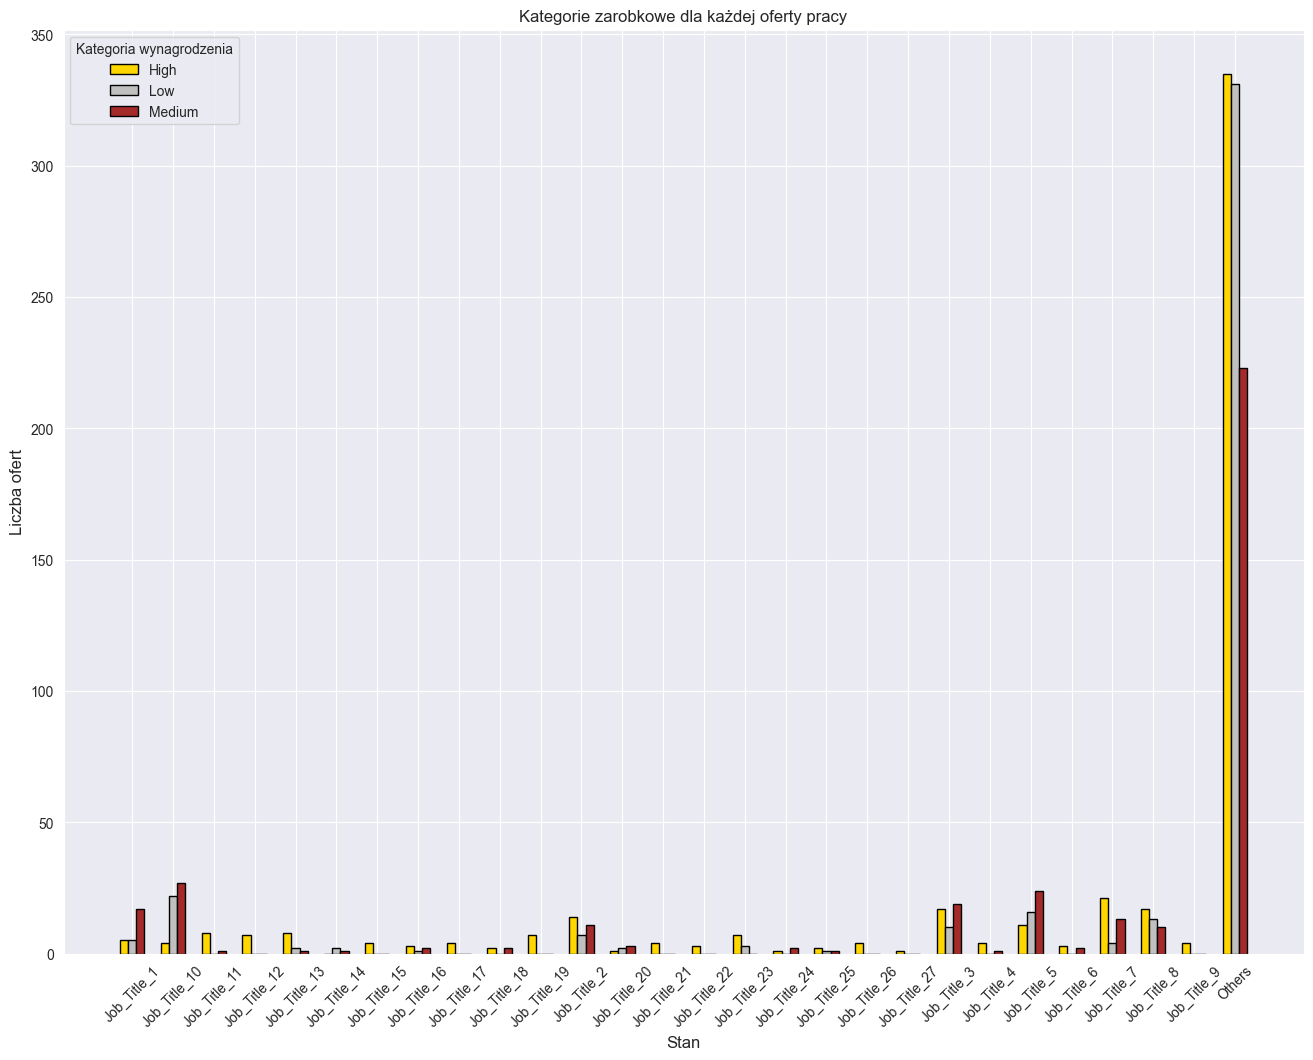

In [17]:
salary_types = train['salary_category'].unique()

show_every_title = train.groupby(['job_title', 'salary_category']).size().unstack(fill_value=0).reindex(columns=salary_types, fill_value=0).stack().reset_index(name='Count')

width = 0.2
x = np.arange(len(show_every_title['job_title'].unique()))
my_xticks = [x - width, x, x + width]
colors = ['gold', 'silver', 'brown']

fig, ax = plt.subplots(figsize=(16, 12))

for i, salary in enumerate(salary_types):
    ax.bar(
        x=my_xticks[i],
        height=show_every_title.loc[(show_every_title['salary_category'] == salary), 'Count'],
        width=width,
        label=salary,
        color=colors[i],
        edgecolor='black',
        alpha=1,
    )

ax.grid(True)
ax.set_xticks(x)
ax.set_xticklabels(show_every_title['job_title'].unique(), rotation=45)
ax.set_xlabel('Stan', fontsize=12)
ax.set_ylabel('Liczba ofert', fontsize=12)
ax.set_title('Kategorie zarobkowe dla każdej oferty pracy')
ax.legend(title='Kategoria wynagrodzenia')

#### Co zrobić z job_title?

Testowane:
- kodowanie one-hot -> nie poprawia
- usunięcie -> narazie najlepiej
- pogrupować tak żeby była przewaga jakiś klas z 'salary_category'. Stworzenie 'job_title_earning' i kodowanie one-hot -> nie poprawia
- zmiana na binary 'is_others_job_title' -> nie testowano

In [18]:
train.loc[train['job_title'] == 'Others', 'is_others_job_title'] = 1
test.loc[train['job_title'] == 'Others', 'is_others_job_title'] = 1

train.loc[train['job_title'] != 'Others', 'is_others_job_title'] = 0
test.loc[train['job_title'] != 'Others', 'is_others_job_title'] = 0

train.drop(columns=['job_title'], inplace=True)
test.drop(columns=['job_title'], inplace=True)

#### <center>Kolumny "feature_"</center>

In [19]:
feature_columns = [col for col in train.columns if col.startswith('feature_')]

train[feature_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature_1   1280 non-null   object 
 1   feature_2   1280 non-null   float64
 2   feature_3   1280 non-null   bool   
 3   feature_4   1280 non-null   bool   
 4   feature_5   1280 non-null   bool   
 5   feature_6   1280 non-null   bool   
 6   feature_7   1280 non-null   bool   
 7   feature_8   1280 non-null   bool   
 8   feature_9   1280 non-null   bool   
 9   feature_10  834 non-null    float64
 10  feature_11  1280 non-null   bool   
 11  feature_12  1280 non-null   bool   
dtypes: bool(9), float64(2), object(1)
memory usage: 41.4+ KB


#### feature_1

In [20]:
grouped_feature_1 = train.groupby(['salary_category', 'feature_1']).size().unstack(fill_value=0)

feature_1_encoder = LabelEncoder().fit(train['feature_1'])
train['feature_1'] = feature_1_encoder.transform(train['feature_1'])
test['feature_1'] = feature_1_encoder.transform(test['feature_1'])

grouped_feature_1

feature_1,A,B,C,D,E
salary_category,,,,,
High,500,0,0,1,0
Low,373,36,6,3,1
Medium,359,0,0,1,0


#### feature_2 (bo jest najwyżej w importance dla xgb, lgb i rf)

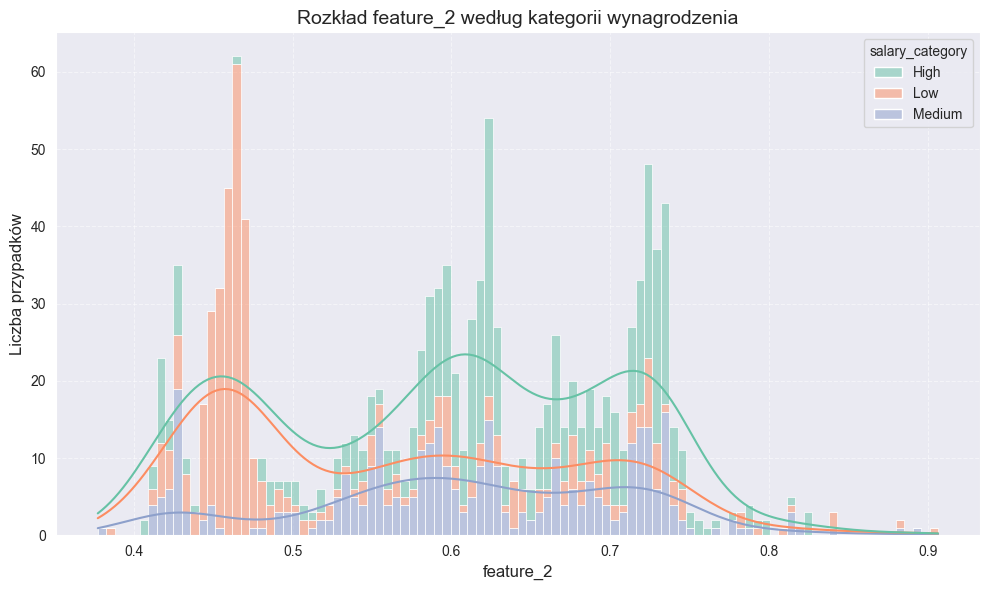

In [21]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(
    data=train,
    x='feature_2',
    hue='salary_category',
    kde=True,
    palette='Set2',
    multiple='stack',
    bins=100,
)

plt.title('Rozkład feature_2 według kategorii wynagrodzenia', fontsize=14)
plt.xlabel('feature_2', fontsize=12)
plt.ylabel('Liczba przypadków', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### feature_10 (bo jest najwięcej NaN)

W feature_10 okres 06-08/2024 ma najwięcej brakujących wartości dla zbioru treningowego.

Tak samo jest w zbiorze testowym.

In [22]:
train_grouped_feature_10 = train.loc[train['feature_10'].isna(), ['month', 'year']]

train_grouped_feature_10.groupby(['year', 'month']).size().sort_values(ascending=False).head(n=3)

year    month
2024.0  7.0      184
        8.0       60
        6.0       29
dtype: int64

In [23]:
test_grouped_feature_10 = test.loc[test['feature_10'].isna(), ['month', 'year']]

test_grouped_feature_10.groupby(['year', 'month']).size().sort_values(ascending=False).head(n=3)

year  month
2024  7        136
      8         28
      6         28
dtype: int64

#### Kodowanie LabelEncoder na salary_category

In [24]:
salary_category = train['salary_category']
salary_category_encoder = LabelEncoder().fit(salary_category)
train['salary_category'] = salary_category_encoder.transform(train['salary_category'])

#### Wartości korelacji dla kolumny salary_category

Usunięcie kolumn mało informatywnych.

In [25]:
test_obs = test['obs']
train.drop(columns=['obs'], inplace=True)
test.drop(columns=['obs'], inplace=True)

corr = train.corr()[['salary_category']]

columns_to_drop = corr.loc[(corr['salary_category'] < 0.02) & (corr['salary_category'] > -0.02), :].index.values

train['salary_category'] = salary_category_encoder.inverse_transform(train['salary_category'])
train.drop(columns=columns_to_drop, inplace=True)
test.drop(columns=columns_to_drop, inplace=True)

test = pd.concat([test_obs, test], axis=1)

In [26]:
train.head()

,salary_category,feature_1,feature_2,feature_3,feature_4,feature_6,feature_7,feature_8,feature_9,feature_10,...,job_desc_298,job_desc_299,job_desc_300,has_description,month,Central,East,None,West,is_others_job_title
0,High,0,0.6429,False,False,True,True,False,False,60.0,...,-0.587955,-0.919095,-0.207340,1,7.0,0.0,1.0,0.0,0.0,1.0
1,Low,0,0.4678,False,False,True,True,True,False,60.0,...,-0.893224,-0.823024,0.112364,1,7.0,0.0,0.0,0.0,1.0,0.0
2,Low,0,0.4610,False,False,True,True,True,False,36.0,...,0.000000,0.000000,0.000000,0,7.0,0.0,0.0,0.0,1.0,1.0
3,Low,0,0.5064,False,False,True,True,True,False,72.0,...,0.000000,0.000000,0.000000,0,7.0,0.0,0.0,0.0,1.0,1.0
4,Low,0,0.4640,False,False,True,True,False,False,48.0,...,-0.696853,-0.601466,0.089939,1,7.0,0.0,0.0,0.0,1.0,1.0


In [27]:
test.head()

,obs,feature_1,feature_2,feature_3,feature_4,feature_6,feature_7,feature_8,feature_9,feature_10,...,job_desc_298,job_desc_299,job_desc_300,has_description,month,Central,East,None,West,is_others_job_title
0,1281,0,0.6473,False,False,True,False,False,False,36.0,...,-0.667958,-0.702116,-0.206267,1,6,0.0,0.0,0.0,1.0,1.0
1,1282,0,0.4238,True,False,False,False,False,False,60.0,...,-1.261702,-0.505897,0.082080,1,8,0.0,1.0,0.0,0.0,0.0
2,1283,0,0.6219,True,False,True,True,False,False,120.0,...,-0.506540,-0.773561,-0.105221,1,1,0.0,0.0,0.0,1.0,1.0
3,1284,0,0.6704,False,False,True,False,False,False,36.0,...,-0.491272,-0.808156,-0.048326,1,6,0.0,1.0,0.0,0.0,1.0
4,1285,0,0.7310,False,False,True,True,False,False,144.0,...,-0.614605,-0.770506,0.142140,1,5,0.0,0.0,0.0,1.0,1.0


## Przybliżenie train do test

- ucięcie przedziałów na train aby zgadzały się z test na podstawie wyniku testu U Manna Whitneya -> nie poprawia
- usunięcie tych kolumn -> nie testowano

In [28]:
from scipy.stats import mannwhitneyu


statistical_tests = pd.DataFrame(
    data={
        'columns': train.columns[1:],
        'umann_pvalue': [mannwhitneyu(train[column], test[column], nan_policy='omit', use_continuity=False, method='asymptotic', alternative='two-sided').pvalue for column in train.columns if column != 'salary_category']
    }
)

check_for_diff = statistical_tests.loc[statistical_tests['umann_pvalue'] <= 0.05, :].sort_values(by='umann_pvalue')

In [29]:
# def cut_ranges(column):
#     test_min, test_max = test[column].min(), test[column].max()
#     return train[(train[column] >= test_min) & (train[column] <= test_max)].reset_index(drop=True)
#
# for column in check_for_diff['columns']:
#     train = cut_ranges(column)
#
# train.info()

train.drop(columns=check_for_diff['columns'], inplace=True)
test.drop(columns=check_for_diff['columns'], inplace=True)

#### Zapisz przygotowane dane

In [30]:
if 'prepared' not in os.listdir(os.getcwd()):
    os.mkdir('prepared')

train.to_csv(os.path.join('prepared', 'train.csv'), index=False)
test.to_csv(os.path.join('prepared', 'test.csv'), index=False)